# Requirements

## Libraries

In [1]:
# !pip install -r requirements.txt

In [2]:
import cv2
from roboflow import Roboflow
from bs4 import BeautifulSoup
import os
import shutil
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import random
from Cavity_detection.src.utils import *
from Cavity_detection.src.secrets import ROBOFLOW_API_KEY, ROBOFLOW_API_KEY_2, ROBOFLOW_API_KEY_3

## Directories and definitions

In [3]:
base_path= 'Cavity_detection'

In [4]:
data = os.path.join(base_path, 'data')
raw_data = os.path.join(data, 'raw')
external_data = os.path.join(data, 'external')
interim_data = os.path.join(data, 'interim')
interim_caries = os.path.join(interim_data, 'caries')
interim_no_caries = os.path.join(interim_data, 'no_caries')
interim_caries_rois = os.path.join(interim_caries, 'rois')
rejected_rois = os.path.join(interim_caries, 'rejected_rois')
processed_data = os.path.join(data, 'processed')
processed_caries = os.path.join(processed_data, 'caries')
processed_no_caries = os.path.join(processed_data, 'no_caries')

In [5]:
directories = [data, raw_data, external_data, interim_data, interim_caries,
               interim_no_caries, interim_caries_rois, rejected_rois, 
               processed_data, processed_caries, processed_no_caries]

In [6]:
empty_directory(interim_data)
empty_directory(processed_data)
empty_directory(external_data)
create_missing_folders(directories)

In [7]:
# clahe creation
clahe = cv2.createCLAHE(clipLimit =10.0, tileGridSize=(8,8)) # Parameters used in original paper

In [8]:
# height and width
height = 100
width = 100

# Raw

## Data download

In [9]:
# download dataset from roboflow to data/external and copy it to data/raw
def download_raw_data(download_dir, raw_data_dir, overwrite_external:bool=False):
  if overwrite_external:
    empty_directory(download_dir)
    empty_directory(raw_data_dir)
  rf = Roboflow(api_key=ROBOFLOW_API_KEY)
  # first image batch
  project = rf.workspace("lesiones-dentales-1").project("dental-lesions-oa6kb")
  dataset = project.version(5).download("voc",
                                        location=download_dir,
                                        overwrite=overwrite_external)
  copy_subfolder_contents(download_dir, 'train', raw_data_dir)
  
  # second image batch
  rf = Roboflow(api_key=ROBOFLOW_API_KEY_2)
  project = rf.workspace("lesiones-dentales-2").project("dental-lesions-2")
  dataset = project.version(4).download("voc",
                                        location=download_dir,
                                        overwrite=overwrite_external)
  copy_subfolder_contents(download_dir, 'train', raw_data_dir)

# third image batch
  rf = Roboflow(api_key=ROBOFLOW_API_KEY_3)
  project = rf.workspace("lesiones-dentales-3").project("dental-lessions3")
  dataset = project.version(1).download("voc",
                                        location=download_dir,
                                        overwrite=overwrite_external)
  copy_subfolder_contents(download_dir, 'train', raw_data_dir)


In [10]:
download_raw_data(external_data, raw_data, True)

loading Roboflow workspace...
loading Roboflow project...
Extracting Dataset Version Zip to Cavity_detection/data/external in voc:: 100%|██████████| 1734/1734 [00:03<00:00, 561.94it/s]


In [11]:
img_counter("Cavity_detection/data/external/train")

866

In [12]:
img_counter(raw_data)

866

# Interim
caries and no_caries separation
caries roi creation (without clahe)
exploratoy analisys

## cavity / no cavity separation

Based on the 'caries' nametag in xml files, separate in 2 directories images that have cavities and those that not

In [13]:
# Open each xml at raw_data and check for 'caries' in nametag to separate in folders
def split_classes(raw_data_path):
  raw_data= raw_data_path

  # empty caries - no_caries paths
  shutil.rmtree(interim_caries, ignore_errors=True)
  shutil.rmtree(interim_no_caries, ignore_errors=True)
  create_missing_folders(directories)

  xmls = [xml for xml in os.listdir(raw_data) if xml.endswith('.xml')]
  for xml in xmls:
    with open(file_path(raw_data, xml)) as f:
      opened_xml = f.read()
    parsed_xml = BeautifulSoup(opened_xml, "xml") # reading xml
    filename = parsed_xml.find('filename').text
    if parsed_xml.find('name', string='caries') is not None: #check for caries nametag
      # copy xml and related image to cavities path
      shutil.copyfile(file_path(raw_data, xml), file_path(interim_caries, xml)) 
      shutil.copyfile(file_path(raw_data, filename), file_path(interim_caries, filename))
    else:
      # copy xml and related image to no cavities path
      shutil.copyfile(file_path(raw_data, xml), file_path(interim_no_caries, xml))
      shutil.copyfile(file_path(raw_data, filename), file_path(interim_no_caries, filename))


In [14]:
split_classes(raw_data)

In [15]:
img_counter(interim_caries)

451

## caries roi creation

In [16]:
def extend_pixels(x_max, x_min, y_max, y_min, height, width, image_height, image_width):

    # Calculate region width and height
    region_width = x_max - x_min
    region_height = y_max - y_min

    # Check if region is smaller than desired width and height
    if region_width < width:
        # Calculate how much to extend on each side
        delta = (width - region_width) // 2
        x_max += delta
        x_min -= delta

        # Check if we went too far to the left
        if x_min < 0:
            x_max -= x_min
            x_min = 0

        # Check if we went too far to the right
        if x_max > image_width:
            x_min -= (x_max - image_width)
            x_max = image_width

    if region_height < height:
        # Calculate how much to extend on each side
        delta = (height - region_height) // 2
        y_max += delta
        y_min -= delta

        # Check if we went too far up
        if y_min < 0:
            y_max -= y_min
            y_min = 0

        # Check if we went too far down
        if y_max > image_height:
            y_min -= (y_max - image_height)
            y_max = image_height

    # Return modified coordinates
    return x_max, x_min, y_max, y_min


In [17]:
def extend_pixels(x_max, x_min, y_max, y_min, height, width, image_height, image_width):

    # Calculate region width and height
    region_width = x_max - x_min
    region_height = y_max - y_min

    # Check if region is smaller than desired width and height
    if region_width < width:
        # Calculate how much to extend on each side
        delta = (width - region_width) // 2
        x_max += delta
        x_min -= delta

        # Check if we went too far to the left
        if x_min < 0:
            x_max -= x_min
            x_min = 0

        # Check if we went too far to the right
        if x_max > image_width:
            x_min -= (x_max - image_width)
            x_max = image_width

    if region_height < height:
        # Calculate how much to extend on each side
        delta = (height - region_height) // 2
        y_max += delta
        y_min -= delta

        # Check if we went too far up
        if y_min < 0:
            y_max -= y_min
            y_min = 0

        # Check if we went too far down
        if y_max > image_height:
            y_min -= (y_max - image_height)
            y_max = image_height

    # Check if image aspect ratio needs to be adjusted
    aspect_ratio = region_width / region_height
    desired_ratio = width / height
    if aspect_ratio != desired_ratio:
        # Calculate new region width and height
        new_width = region_height * desired_ratio
        new_height = region_width / desired_ratio

        # Extend in the necessary direction
        if new_width > region_width:
            delta = (new_width - region_width) // 2
            x_max += delta
            x_min -= delta

            # Check if we went too far to the left
            if x_min < 0:
                x_max -= x_min
                x_min = 0

            # Check if we went too far to the right
            if x_max > image_width:
                x_min -= (x_max - image_width)
                x_max = image_width
        else:
            delta = (new_height - region_height) // 2
            y_max += delta
            y_min -= delta

            # Check if we went too far up
            if y_min < 0:
                y_max -= y_min
                y_min = 0

            # Check if we went too far down
            if y_max > image_height:
                y_min -= (y_max - image_height)
                y_max = image_height

    # Return modified coordinates
    return int(x_max), int(x_min), int(y_max), int(y_min)


In [18]:
# Create and save roi's, applying clahe by default (needs to be applied to the full image first)
def roi_creation_extending_pixels(images_path, save_dir, apply_clahe:bool=True, visual_compare:bool=False, empty_roi_dir:bool=True, height:int=None, width:int=None, percentage:float=None, rejected_dir:str=None):
  if empty_roi_dir:
    empty_directory(save_dir)
    empty_directory(rejected_dir)

  cavity_counter = 0
  for xml in os.listdir(images_path):
      if xml.endswith('.xml'): # Check only xml files
        with open(file_path(images_path, xml)) as f:
          opened_xml = f.read()
        parsed_xml = BeautifulSoup(opened_xml, "xml")
        filename = parsed_xml.find('filename').text
        cavities = [cavity.find_parent() for cavity in parsed_xml.find_all('name', string='caries')] # List of cavities per file
        for cavity in cavities:
          # save coordinates of each cavity
          x_min = int(cavity.find('bndbox').find('xmin').string)
          x_max = int(cavity.find('bndbox').find('xmax').string)
          y_min = int(cavity.find('bndbox').find('ymin').string)
          y_max = int(cavity.find('bndbox').find('ymax').string)


          # image reading and processing
          if apply_clahe:
            img = cv2.imread(file_path(images_path, filename),cv2.IMREAD_GRAYSCALE) # read img as grayscale
            img = clahe.apply(img)
          else:
            img = cv2.imread(file_path(images_path, filename),cv2.IMREAD_UNCHANGED) # read img as it is

          # pixel extention
          img_height = img.shape[0] 
          img_width = img.shape[1]
          x_max, x_min, y_max, y_min = extend_pixels(x_max, x_min, y_max, y_min, height, width, img_height, img_width)
          roi = img[ y_min:y_max,x_min:x_max] #axes are y:x
          
          # verify roi ratio to image
          roi_height, roi_width = roi.shape
          roi_area = roi_height * roi_width
          roi_ratio = roi_area / (height*width)

          if roi_ratio < percentage:
            cv2.imwrite(file_path(rejected_dir, str(cavity_counter) + '.jpg'),roi) # save roi to rejected_dir
          else:
            cv2.imwrite(file_path(save_dir, str(cavity_counter) + '.jpg'),roi) # save roi to save_dir

          if visual_compare:
            # bounding_box for visualization
            boxA = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=1, edgecolor='r', facecolor='none')
            # Image comparation
            fig, axes = plt.subplots(nrows=1, ncols=2)
            axes[0].imshow(img,cmap=plt.cm.gray)
            axes[0].add_patch(boxA)
            axes[1].imshow(roi,cmap=plt.cm.gray)
            fig.tight_layout()
            plt.rcParams['figure.figsize'] = [10, 10]
            plt.show()
            print(file_path(save_dir, str(cavity_counter) + '.jpg'), '\n')

          cavity_counter += 1


In [19]:
# Create and save roi's, applying clahe by default (needs to be applied to the full image first)
def roi_creation(images_path, save_dir, apply_clahe:bool=True, visual_compare:bool=False, empty_roi_dir:bool=True, height:int=None, width:int=None, percentage:float=None, rejected_dir:str=None):
  if empty_roi_dir:
    empty_directory(save_dir)
    empty_directory(rejected_dir)

  cavity_counter = 0
  for xml in os.listdir(images_path):
      if xml.endswith('.xml'): # Check only xml files
        with open(file_path(images_path, xml)) as f:
          opened_xml = f.read()
        parsed_xml = BeautifulSoup(opened_xml, "xml")
        filename = parsed_xml.find('filename').text
        cavities = [cavity.find_parent() for cavity in parsed_xml.find_all('name', string='caries')] # List of cavities per file
        for cavity in cavities:
          # save coordinates of each cavity
          x_min = int(cavity.find('bndbox').find('xmin').string)
          x_max = int(cavity.find('bndbox').find('xmax').string)
          y_min = int(cavity.find('bndbox').find('ymin').string)
          y_max = int(cavity.find('bndbox').find('ymax').string)

          # image reading and processing
          if apply_clahe:
            img = cv2.imread(file_path(images_path, filename),cv2.IMREAD_GRAYSCALE) # read img as grayscale
            clahe_img = clahe.apply(img)
            roi = clahe_img[ y_min:y_max,x_min:x_max] #axes are y:x
          else:
            img = cv2.imread(file_path(images_path, filename),cv2.IMREAD_UNCHANGED) # read img as it is
            roi = img[ y_min:y_max,x_min:x_max] #axes are y:x
          

          # verify roi ratio to image
          roi_height, roi_width = roi.shape
          roi_area = roi_height * roi_width
          roi_ratio = roi_area / (height*width)

          img_filename = f'{cavity_counter}_{roi_ratio}.jpg'
          if roi_ratio < percentage:
            cv2.imwrite(file_path(rejected_dir, img_filename),roi) # save roi to rejected_dir
          else:
            cv2.imwrite(file_path(save_dir, img_filename),roi) # save roi to save_dir

          if visual_compare:
            # bounding_box for visualization
            boxA = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=1, edgecolor='r', facecolor='none')
            # Image comparation
            fig, axes = plt.subplots(nrows=1, ncols=2)
            axes[0].imshow(img,cmap=plt.cm.gray)
            axes[0].add_patch(boxA)
            axes[1].imshow(roi,cmap=plt.cm.gray)
            fig.tight_layout()
            plt.rcParams['figure.figsize'] = [10, 10]
            plt.show()
            print(file_path(save_dir, str(cavity_counter) + '.jpg'), '\n')

          cavity_counter += 1


In [20]:
roi_creation(interim_caries,interim_caries_rois, visual_compare=False, height=height, width=width, percentage=0.5, rejected_dir=rejected_rois)

In [21]:
caries_number = img_counter(interim_caries_rois)
caries_number

447

In [22]:
img_counter(rejected_rois)

135

## no_caries roi creation

In [23]:
def extract_random_regions(src_dir, dest_dir, num_regions, height, width, apply_clahe=True):
    empty_directory(processed_no_caries)
    create_missing_folders(directories)
    counter = 0
    filenames = [f for f in os.listdir(src_dir) if f.endswith(".jpg") or f.endswith(".png")]
    while counter < num_regions:
        filename = random.choice(filenames)
        img_path = os.path.join(src_dir, filename)

        # image reading and processing
        if apply_clahe:
          img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) # read img as grayscale
          clahe_img = clahe.apply(img)
        else:
          img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED) # read img as it is

        # extract region from apropiate
        if len(img.shape) == 2:
                h, w = img.shape
                c = 1
        else:
          h, w, c = img.shape

        # random coordinates of the region
        x1 = random.randint(0, w - width)
        y1 = random.randint(0, h - height)
        x2 = x1 + width
        y2 = y1 + height

        if c == 1:
          region = img[y1:y2, x1:x2]
        else:
          region = img[y1:y2, x1:x2, :]

        region_filename = f"{counter}.jpg"
        region_path = os.path.join(dest_dir, region_filename)
        cv2.imwrite(region_path, region)
        counter += 1


In [24]:
extract_random_regions(interim_no_caries,processed_no_caries,caries_number,height, width)

In [25]:
img_counter(processed_no_caries)

447

# Data exploratory analysis

## roi's sizes

In [26]:
def get_picture_dimensions(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
            try:
                image = Image.open(os.path.join(directory, filename))
                images.append([filename, image.height, image.width])
            except IOError:
                print("Cannot open", filename)
    return pd.DataFrame(images, columns=['Filename', 'Height', 'Width'])


In [27]:
roi_sizes_df = get_picture_dimensions(interim_caries_rois)

In [28]:
roi_sizes_df.describe()

,Height,Width
count,447.000000,447.000000
mean,144.756152,133.812081
std,60.948416,58.532774
min,36.000000,32.000000
25%,100.000000,93.000000
50%,136.000000,120.000000
75%,178.500000,162.000000
max,455.000000,380.000000


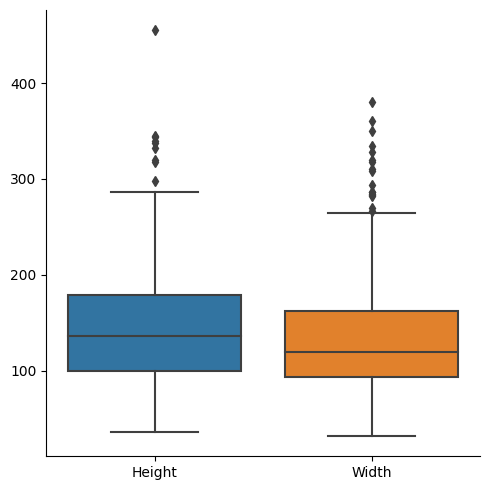

In [29]:
sns.catplot(data=roi_sizes_df, kind='box')
# sns.swarmplot(data=roi_sizes_df, color='black',alpha=0.5)

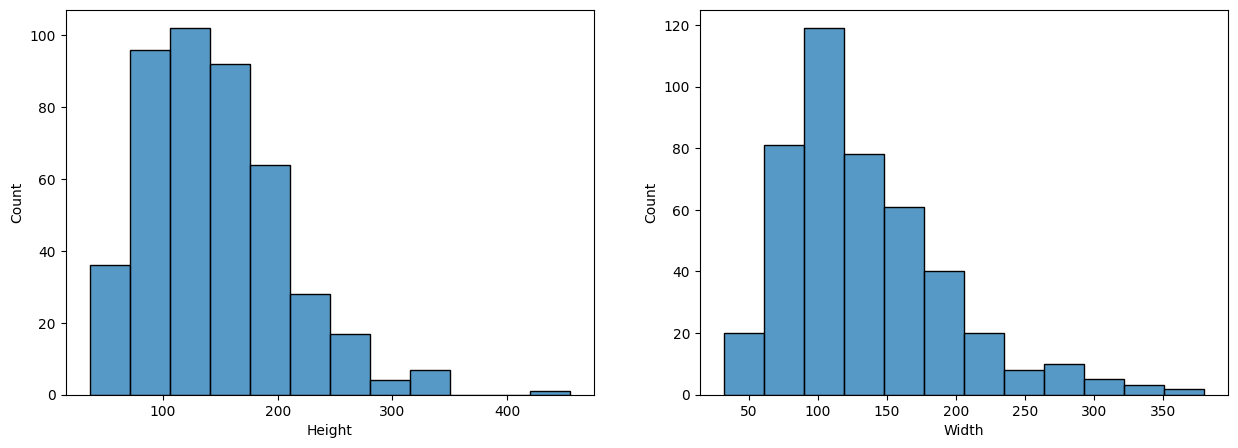

In [30]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
sns.histplot(ax = axes[0], data=roi_sizes_df, x='Height', bins=12)
sns.histplot(ax = axes[1], data=roi_sizes_df, x='Width', bins=12)
plt.show()

# Processing

## Gauss noise padding

In [31]:
def gauss_padding(image, height, width):
    # Get image shape
    if len(image.shape) == 2:
        h, w = image.shape
        c = 1
    else:
        h, w, c = image.shape # (height, width, channels)

    # Calculate scaling factor
    scaling_factor = min(height / h, width / w)

    # Generate Gaussian noise with same mean and standard deviation as the original image
    noise = np.random.normal(np.mean(image), np.std(image), (height, width, c))

    # Resize image while keeping aspect ratio
    if scaling_factor < 1:
        image = cv2.resize(image, (0,0), fx=scaling_factor, fy=scaling_factor)
        if len(image.shape) == 2:
            h, w = image.shape
            c = 1
        else:
            h, w, c = image.shape

    # center the image in the noise array
    if c == 1:
      noise = np.squeeze(noise)
      noise[(height - h)//2:(height - h)//2 + h, (width - w)//2:(width - w)//2 + w] = image
    else:
      noise[(height - h)//2:(height - h)//2 + h, (width - w)//2:(width - w)//2 + w, :] = image

    return noise


In [32]:
# apply gauss noise padding to all directory
def process_images(input_dir, output_dir, height, width):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Get list of files in input directory
    files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

    for file in files:
        # Load image from file
        image = cv2.imread(os.path.join(input_dir, file), cv2.IMREAD_UNCHANGED)

        # Center and add noise to image
        result = gauss_padding(image, height, width)

        # Save result to output directory
        cv2.imwrite(os.path.join(output_dir, file), result)


In [33]:
process_images(interim_caries_rois, processed_caries,height, width)

# Dataset creation

## Using keras

In [34]:
import tensorflow as tf
import numpy as np
import os

2023-03-17 17:14:33.761282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 17:14:33.875038: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-17 17:14:33.877879: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/venv/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-17 17:14:33.877893:

In [35]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object
datagen = ImageDataGenerator(rescale=1./255)

# Define the path to the folders containing the images
train_data_path = processed_data

# Use the ImageDataGenerator to read images from the folders
train_generator = datagen.flow_from_directory(
        train_data_path,
        target_size=(height, width),
        batch_size=32,
        color_mode='grayscale',
        class_mode='binary')

Found 894 images belonging to 2 classes.


In [36]:
image_batch, label_batch = next(train_generator)

In [37]:
img = np.squeeze(image_batch)
plt.imshow(img[23,:,:])

## As numpy arrays

In [38]:
img_counter(processed_caries)

447

In [39]:
import numpy as np
import os
import cv2

def load_data(data_dir):
    classes = ['no_caries', 'caries']
    images = []
    labels = []
    for class_id, class_name in enumerate(classes):
        class_path = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            image = image/255.0 # pixel normalization
            images.append(image)
            labels.append(class_id)
    return np.array(images), np.array(labels)



In [40]:
# Load the data
X, y = load_data(processed_data)

In [41]:
X.shape

(894, 100, 100)

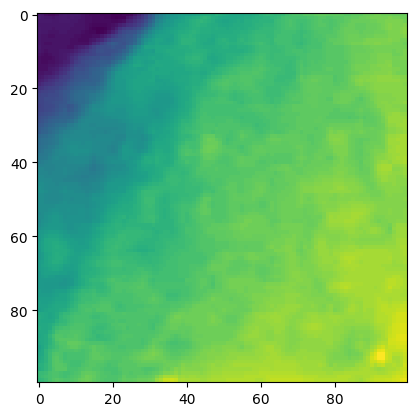

235: 0


In [42]:
n = np.random.randint(0, X.shape[0])
plt.imshow(X[n])
plt.show()
print(f'{n}: {y[n]}')

In [43]:
X[n]

array([[0.20392157, 0.2       , 0.19215686, ..., 0.46666667, 0.46666667,
        0.46666667],
       [0.20784314, 0.20392157, 0.2       , ..., 0.4745098 , 0.47058824,
        0.47058824],
       [0.20392157, 0.20392157, 0.20392157, ..., 0.47843137, 0.47843137,
        0.4745098 ],
       ...,
       [0.43137255, 0.43137255, 0.43529412, ..., 0.51764706, 0.52156863,
        0.52941176],
       [0.43137255, 0.43529412, 0.43921569, ..., 0.5254902 , 0.52941176,
        0.53333333],
       [0.42352941, 0.42745098, 0.43529412, ..., 0.52941176, 0.5372549 ,
        0.54117647]])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8f63fdc3-7b28-4cc7-8735-09f23d070fd3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>